# 7. Мини-проект. Практика

### Постановка задачи

Загрузить датасет с данными о квартирах и их стоимости  для решения задачи регрессии. 

Сделать первичный анализ, подготовить признаки, которые будут использоваться и проанализировать их распределения. Лучше работать с целевой переменной, применив к ней логарифм. После предсказания значение можно будет перевести обратно, сделав степенью экспоненты.

Сделать модель байесовской линейной регрессии с выбранными признаками.

На тех же самых признаках построить линейную регрессию из sklearn и сравнить получившиеся коэффициенты классической линейной регрессии с коэффициентами при признаках в байесовской линейной регрессии (при помощи pm.summary(trace)). 

<a id='0'></a> 
### План проекта
<a href='#1'> **Данные и библиотеки**    
<a href='#2'> **Первичный анализ и подготовка признаков**    
<a href='#3'> **Подготовка признаков**  
<a href='#4'> **Модель байесовской линейной регрессии**  
<a href='#5'> **Модель линейной регрессии sklearn**  
<a href='#6'> **Выводы**      

<a id='1'></a> 
### Данные и библиотеки

<a href='#0'> *Вернуться к плану проекта*

In [321]:
import arviz as az
import pandas as pd
import numpy as np
import os
import scipy
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import matplotlib.lines as mlines
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [150]:
path = r'F:\SkillFactory\Y2_U20'
df = pd.read_csv(os.path.join(path,"flats.csv"), sep=',')

In [151]:
df.tail(5)

,Unnamed: 0,price_doc,full_sq,life_sq,num_room,kitch_sq
6037,30462,10544070,47,30.0,1.0,10.0
6038,30463,12000000,56,29.0,2.0,11.0
6039,30467,25000000,86,59.0,4.0,10.0
6040,30469,13500000,64,32.0,2.0,11.0
6041,30470,5600000,43,28.0,2.0,6.0


In [152]:
#Переименование колонок
df.columns = ['id'] + df.columns.tolist()[1:]

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6042 entries, 0 to 6041
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         6042 non-null   int64  
 1   price_doc  6042 non-null   int64  
 2   full_sq    6042 non-null   int64  
 3   life_sq    6042 non-null   float64
 4   num_room   6042 non-null   float64
 5   kitch_sq   6042 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 283.3 KB


In [154]:
df['price_doc'].agg(['min','max'])

min      500000
max    95122496
Name: price_doc, dtype: int64

<a id='2'></a> 
### Первичный анализ и подготовка признаков

<a href='#0'> *Вернуться к плану проекта*

In [155]:
#Уникальность поля
df['id'].nunique()

6042

In [156]:
#Удаляем признак в силу его уникальности
df = df.drop(columns='id')

In [157]:
#Экономим память на типах данных, данные определенно должны быть целого типа:
for col in df.columns: #['life_sq', 'num_room','kitch_sq','price_log']:
    df[col] = df[col].astype('int32')

In [158]:
#Пусть цена  будет в млн. рублей
df['price_doc'] = df['price_doc']/1000000

In [159]:
df['price_doc'].agg(['min','max','mean'])

min      0.500000
max     95.122496
mean     8.750423
Name: price_doc, dtype: float64

Что представляет собой рынок жилья, какое количество комнат?

In [160]:
df['num_room'].value_counts()

2     2402
1     1960
3     1472
4      180
5       17
6        4
8        3
7        1
0        1
17       1
9        1
Name: num_room, dtype: int64

Количество комнат = 0 - это явная ошибка, выясняем какое количество комнат характерно для данной площади и заменяем 0 на найденное количество комнат:

In [161]:
df[df['num_room']==0]

,price_doc,full_sq,life_sq,num_room,kitch_sq
4590,1.0,30,18,0,6


In [162]:
df[df['full_sq']==30]['num_room'].mean()

1.0

In [163]:
df['num_room'] = np.where(df['num_room']==0,1,df['num_room'])

Смотрим на выбросы по количеству комнат: 7, 8, 9, 17:

<AxesSubplot:>

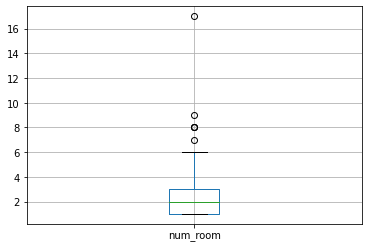

In [164]:
df.boxplot(column=['num_room'])

In [165]:
df[df['num_room']>6]

,price_doc,full_sq,life_sq,num_room,kitch_sq
2755,24.267600,177,119,8,17
2771,25.500000,145,109,7,9
3623,35.000000,159,115,8,14
4977,13.150000,51,30,17,8
5474,95.122496,220,144,9,17
5780,42.300000,187,139,8,13


Если 7, 8, 9 комнат на жилой площади > 100 кв м кажется вполне логичным, то 17 комнат на жилой площади 30 - явная ошибка.
Посмотрим сколько комнат располагается в среднем по датасету на такой площади (исходим из того, что жилье все-таки в основном типовое)

In [166]:
df[(df['life_sq']==30) & (df['full_sq']==51) & ~(df['num_room']==17)]['num_room'].mean()

2.0

Итак, это все-таки не 17 комнат, а всего лишь 2:

In [167]:
df['num_room'] = np.where(df['num_room']==17,2,df['num_room'])

<AxesSubplot:>

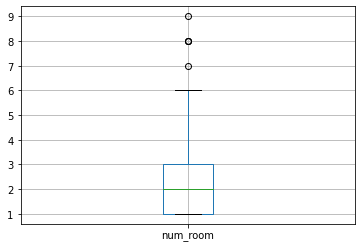

In [168]:
df.boxplot(column=['num_room'])

7,8,9 комнат на жилой площади >=109 кв.м и  общей >=145 вполне логичны, несмотря на то, что статистически выглядят выбросами. Но их на рынке просто не так много

2    2403
1    1961
3    1472
4     180
5      17
6       4
8       3
7       1
9       1
Name: num_room, dtype: int64

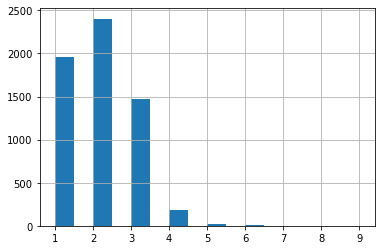

In [169]:
df['num_room'].hist(bins=16)
df['num_room'].value_counts()

Теперь будем разбираться с площадью. Здесь одной визуализации будет мало.
Начнем с общей площади, минимальное значение 1 кв.м:

In [170]:
df['full_sq'].agg(['min','max'])

min      1
max    637
Name: full_sq, dtype: int64

Посмотрим на все квартиры, у которых площадь общая < 10 кв.м И если квартира с 1 кв

In [171]:
df[df['full_sq']<10]

,price_doc,full_sq,life_sq,num_room,kitch_sq
2256,13.066000,1,1,1,1
2657,6.675730,1,1,1,1
3773,14.923206,1,47,1,1
4023,13.452318,1,1,1,1
4461,17.035200,1,1,1,1


Общая площадь 1, жилая - 47, явная опечатка, посмотрим на среднее значение общей площади подобных квартир, с кухней 1кв.м, что явно говорит, что это скорее всего студия. Тогда и общая площадь должна быть 47 кв.м

In [172]:
df['full_sq'] = np.where((df['life_sq']==47) & (df['full_sq']==1),47,df['full_sq'])
df = df[~(df['full_sq']<10)]

Посмотрим на жилую площадь:

In [173]:
df['life_sq'].agg(['min','max'])

min      0
max    637
Name: life_sq, dtype: int64

Вполне можно пожертвовать 34-ю записямт с жилой площадью < 8 кв.м:

In [174]:
df[df['life_sq']<8].count()

price_doc    34
full_sq      34
life_sq      34
num_room     34
kitch_sq     34
dtype: int64

In [175]:
df = df[~(df['life_sq']<8)]

При этом мы убрали и квартиры с обще площадью < 10 кв.м:

In [176]:
df[df['full_sq']<10]

,price_doc,full_sq,life_sq,num_room,kitch_sq


In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6004 entries, 0 to 6041
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price_doc  6004 non-null   float64
 1   full_sq    6004 non-null   int32  
 2   life_sq    6004 non-null   int32  
 3   num_room   6004 non-null   int32  
 4   kitch_sq   6004 non-null   int32  
dtypes: float64(1), int32(4)
memory usage: 187.6 KB


In [178]:
df[['full_sq','life_sq']].agg(['min','max'])

,full_sq,life_sq
min,11,8
max,637,637


Явная аномалия: жилая площадь > общей:

In [179]:
df[df['life_sq']>df['full_sq']]

,price_doc,full_sq,life_sq,num_room,kitch_sq
72,13.75,77,458,3,10
5726,11.00,56,57,3,5


Общая площадь 77, жилая - 458, явная опечатка, д.б. 46 кв.м c учетом округления:

In [180]:
df['life_sq'] = np.where((df['life_sq']==458) & (df['full_sq']==77),46,df['life_sq'])

И, наконец, 3-комнатная квартира с общей площадью 56 и жилой 57, смотрим на аналогичные квартиры:

In [181]:
df[(df['life_sq']==57)&(df['num_room']==3)]

,price_doc,full_sq,life_sq,num_room,kitch_sq
318,7.000000,118,57,3,17
1098,32.000000,126,57,3,14
2446,15.500000,93,57,3,17
3938,16.500000,104,57,3,16
4222,8.600000,58,57,3,6
4576,37.600000,120,57,3,11
4997,19.350000,81,57,3,9
5289,42.000000,103,57,3,12
5340,8.370000,96,57,3,9
5423,15.404915,97,57,3,10


Здесь мы находим еще аналогичную квартиру: 58/57/6. 3х комнатные квартиры с общей площадью 56 и 58 кв.м и кухней 5-6 кв.м немогут иметь жилую площадь 57 кв.м, скорее всего это 47 кв.м

In [182]:
df['life_sq'] = np.where((df['life_sq']==57)&(df['num_room']==3)&(df['kitch_sq']<7),47,df['life_sq'])

<AxesSubplot:>

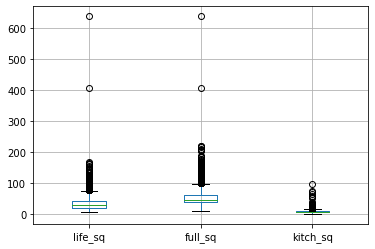

In [183]:
df.boxplot(column=['life_sq','full_sq','kitch_sq'])

Посмотрим на выбросы в площади > 400 кв.м:

In [184]:
df[df['life_sq']>400]

,price_doc,full_sq,life_sq,num_room,kitch_sq
3898,4.725142,637,637,2,10
5315,3.134129,407,407,1,10


Видно, что эти квартиры являются очень специфическими и при исследовании могут сильно повлиять на результаты, поэтому лучше их вообще убрать из исследования:

In [185]:
df = df[~(df['life_sq']>400)]

<AxesSubplot:>

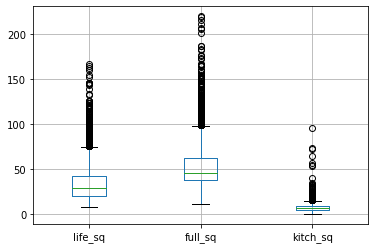

In [186]:
df.boxplot(column=['life_sq','full_sq','kitch_sq'])

Из ящика с усами видно, что мы избавились от нижних выбросов по площадям, а вот верхние границы выбросов мы не трогали, кроме совсем эксклюзивных вариантов. 

Итак, получился датасет из 6002 записей:

In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6002 entries, 0 to 6041
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price_doc  6002 non-null   float64
 1   full_sq    6002 non-null   int32  
 2   life_sq    6002 non-null   int32  
 3   num_room   6002 non-null   int32  
 4   kitch_sq   6002 non-null   int32  
dtypes: float64(1), int32(4)
memory usage: 187.6 KB


Теперь посмотрим на распределение цены квартир по количеству комнат: 

,min,max,mean,std,count
num_room,,,,,
1,0.500000,80.777440,6.096113,3.524546,1939
2,0.990000,35.905920,7.837517,3.797254,2390
3,0.990000,65.000000,11.956053,6.948065,1468
4,1.000000,65.000000,19.442508,13.325799,179
5,2.000000,60.000000,25.385294,15.764852,17
6,8.000000,70.000000,30.775000,27.657714,4
7,25.500000,25.500000,25.500000,NaN,1
8,24.267600,42.300000,33.855867,9.070482,3
9,95.122496,95.122496,95.122496,NaN,1


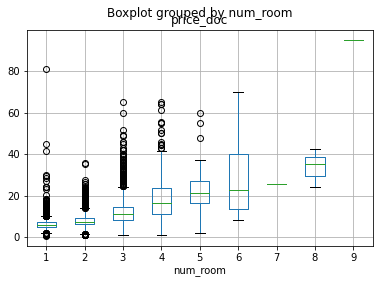

In [188]:
df.boxplot(column=['price_doc'], by='num_room')
df.groupby('num_room')['price_doc'].agg(['min','max','mean','std','count'])

Здесь хорошо видно, что нужно исключить из рассмотрения 7 и 9 - комнатные квартиры - они единственные в датасете. Убрать нежелательные выбросы.

In [189]:
df = df[~((df['num_room']==7)|(df['num_room']==9))]

,min,max,mean,std,count
num_room,,,,,
1,0.5000,80.77744,6.096113,3.524546,1939
2,0.9900,35.90592,7.837517,3.797254,2390
3,0.9900,65.00000,11.956053,6.948065,1468
4,1.0000,65.00000,19.442508,13.325799,179
5,2.0000,60.00000,25.385294,15.764852,17
6,8.0000,70.00000,30.775000,27.657714,4
8,24.2676,42.30000,33.855867,9.070482,3


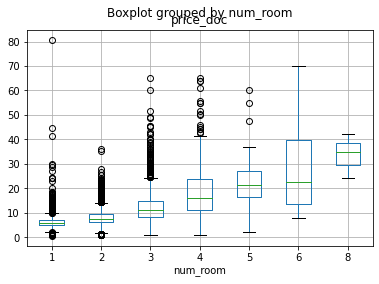

In [190]:
df.boxplot(column=['price_doc'], by='num_room')
df.groupby('num_room')['price_doc'].agg(['min','max','mean','std','count'])

Теперь поработаем с нижними границами 1 - и 2 - комнатных квартир статистическими методами:

In [191]:
df_tmp = df[df['num_room']==2]
iqr = scipy.stats.iqr(df_tmp['price_doc'])
print(iqr)

3.1500000000000004


In [192]:
df_tmp[df_tmp.price_doc<np.percentile(df_tmp.price_doc,25) - 1.5*iqr].price_doc.count()

112

In [201]:
del_index = df[df['num_room']==2][df[df['num_room']==2].price_doc<np.percentile(df[df['num_room']==2].price_doc,25) - 1.5*iqr].index
df = df.loc[list(set(df.index)-set(del_index.tolist()))]

In [225]:
df_tmp = df[df['num_room']==1]
iqr = scipy.stats.iqr(df_tmp['price_doc'])
print(iqr)

2.0


In [226]:
df_tmp[df_tmp.price_doc<np.percentile(df_tmp.price_doc,25) - 1.5*iqr].price_doc.count()

135

In [227]:
del_index = df[df['num_room']==1][df[df['num_room']==1].price_doc<np.percentile(df[df['num_room']==1].price_doc,25) - 1.5*iqr].index
df = df.loc[list(set(df.index)-set(del_index.tolist()))]

In [228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5753 entries, 0 to 6041
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price_doc  5753 non-null   float64
 1   full_sq    5753 non-null   int32  
 2   life_sq    5753 non-null   int32  
 3   num_room   5753 non-null   int32  
 4   kitch_sq   5753 non-null   int32  
dtypes: float64(1), int32(4)
memory usage: 179.8 KB


,min,max,mean,std,count
num_room,,,,,
1,2.0000,80.77744,6.471224,3.365561,1804
2,1.5550,35.90592,8.172079,3.569078,2278
3,0.9900,65.00000,11.956053,6.948065,1468
4,1.0000,65.00000,19.442508,13.325799,179
5,2.0000,60.00000,25.385294,15.764852,17
6,8.0000,70.00000,30.775000,27.657714,4
8,24.2676,42.30000,33.855867,9.070482,3


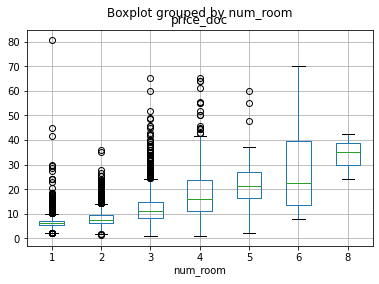

In [230]:
df.boxplot(column=['price_doc'], by='num_room')
df.groupby('num_room')['price_doc'].agg(['min','max','mean','std','count'])

<AxesSubplot:>

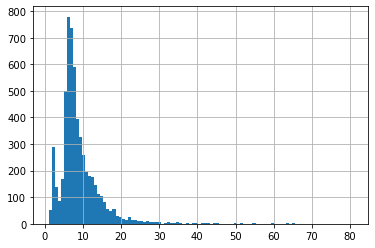

In [231]:
df['price_doc'].hist(bins=100)

In [232]:
df['price_log'] = np.log(df['price_doc'])

<AxesSubplot:>

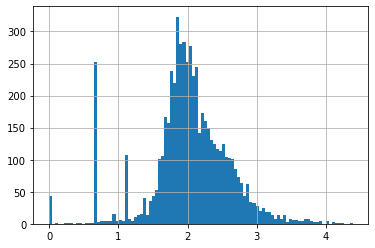

In [233]:
df['price_log'].hist(bins=100)

Статистическая оценка квадратных метров показывает, что 251, 162, 123 объекта из общей, жилой и кухонной площади соответственно имеют аномально большие значения:

In [234]:
iqr = scipy.stats.iqr(df.full_sq)
print(iqr)
df[df.full_sq>np.percentile(df.full_sq,75) + 1.5*iqr].full_sq.count()

25.0


222

In [235]:
iqr = scipy.stats.iqr(df.life_sq)
print(iqr)
df[df.life_sq>np.percentile(df.life_sq,75) + 1.5*iqr].life_sq.count()

22.0


160

In [236]:
iqr = scipy.stats.iqr(df.kitch_sq)
print(iqr)
df[df.kitch_sq>np.percentile(df.kitch_sq,75) + 1.5*iqr].kitch_sq.count()

4.0


118

Пожертвуем 162 записи на очистку датасета(это только 2.7%):

In [237]:
iqr = scipy.stats.iqr(df.full_sq)
print(iqr)
df[df.full_sq>np.percentile(df.full_sq,75) + 1.5*iqr].full_sq.count()

25.0


222

In [238]:
df = df[~(df.full_sq>np.percentile(df.full_sq,75) + 1.5*iqr)]

In [239]:
(162/6040)*100

2.682119205298013

In [240]:
iqr = scipy.stats.iqr(df.life_sq)
print(iqr)
df[df.life_sq>np.percentile(df.life_sq,75) + 1.5*iqr].life_sq.count()

21.0


64

In [241]:
df = df[~(df.life_sq>np.percentile(df.life_sq,75) + 1.5*iqr)]

In [242]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5467 entries, 0 to 6041
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price_doc  5467 non-null   float64
 1   full_sq    5467 non-null   int32  
 2   life_sq    5467 non-null   int32  
 3   num_room   5467 non-null   int32  
 4   kitch_sq   5467 non-null   int32  
 5   price_log  5467 non-null   float64
dtypes: float64(2), int32(4)
memory usage: 213.6 KB


<AxesSubplot:>

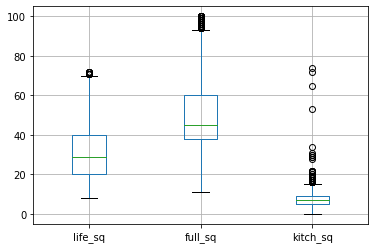

In [243]:
df.boxplot(column=['life_sq','full_sq','kitch_sq'])

In [244]:
df['num_room'].unique()

array([1, 2, 3, 4, 5, 6])

<AxesSubplot:title={'center':'full_sq'}, xlabel='num_room'>

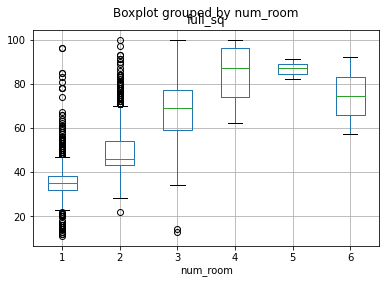

In [245]:
df.boxplot(column=['full_sq'], by='num_room')

In [246]:
df[(df['full_sq']<25)&(df['num_room']==2)]

,price_doc,full_sq,life_sq,num_room,kitch_sq,price_log
1987,3.45,22,22,2,7,1.238374


In [247]:
df = df[~((df['full_sq']<25)&(df['num_room']==2))]
df = df[~((df['full_sq']<25)&(df['num_room']==3))]

<AxesSubplot:title={'center':'full_sq'}, xlabel='num_room'>

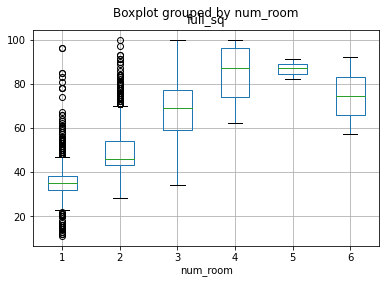

In [248]:
df.boxplot(column=['full_sq'], by='num_room')

Посмотрим на распределение цен:

<AxesSubplot:>

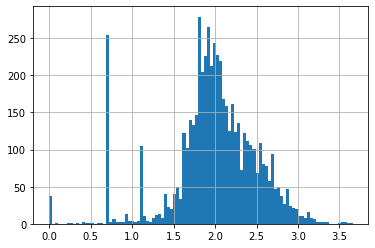

In [261]:
df['price_log'].hist(bins=100)

C:\Users\Nata\Anaconda3\envs\pymc_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Nata\Anaconda3\envs\pymc_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Nata\Anaconda3\envs\pymc_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

price_doc                  
               std       mean median
num_room                            
1         2.250137   6.265268   6.10
2         3.377086   8.066935   7.50
3         5.000946  10.890306  10.55
4         5.603940  13.660204  13.00
5         1.521786  15.716667  16.25

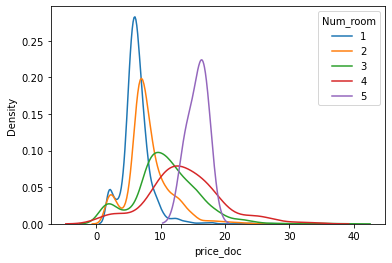

In [259]:
for i in range(1,7):
    sns.distplot(df[df['num_room']==i]['price_doc'], hist=False, label=str(i))
plt.legend(title='Num_room', loc='upper right')    
df.groupby('num_room').agg({'price_doc': {'mean','median','std'}})   

In [260]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5459 entries, 0 to 6041
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price_doc  5459 non-null   float64
 1   full_sq    5459 non-null   int32  
 2   life_sq    5459 non-null   int32  
 3   num_room   5459 non-null   int32  
 4   kitch_sq   5459 non-null   int32  
 5   price_log  5459 non-null   float64
dtypes: float64(2), int32(4)
memory usage: 213.2 KB


<a id='3'></a> 
### Подготовка признаков

<a href='#0'> *Вернуться к плану проекта*

In [252]:
df['price_log'] = np.log(df['price_doc'])

<AxesSubplot:>

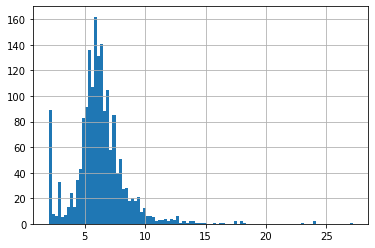

In [262]:
df[df['num_room']==1]['price_doc'].hist(bins=100)

,min,max,mean,std
num_room,,,,
1,2.000,27.20,6.265268,2.250137
2,1.555,35.25,8.066935,3.377086
3,0.990,39.00,10.890306,5.000946
4,1.000,32.50,13.284158,5.926856
5,14.000,16.90,15.716667,1.521786
6,8.000,15.40,11.700000,5.232590


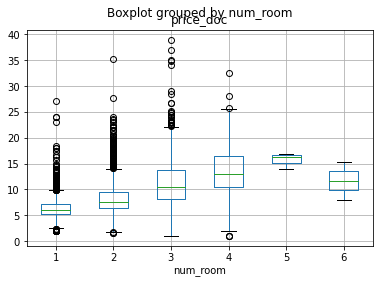

In [254]:
df.boxplot(column=['price_doc'], by='num_room')
df.groupby('num_room')['price_doc'].agg(['min','max','mean','std'])

In [255]:
df = df[~((df['price_doc']<1.5)&(df['num_room']==2))]
df = df[~((df['price_doc']<1)&(df['num_room']==1))]

In [256]:
df = df[~((df['price_doc']<1.1)&(df['num_room']==4))]
df = df[~((df['num_room']==6))]

,min,max,mean,std
num_room,,,,
1,2.000,27.20,6.265268,2.250137
2,1.555,35.25,8.066935,3.377086
3,0.990,39.00,10.890306,5.000946
4,2.000,32.50,13.660204,5.603940
5,14.000,16.90,15.716667,1.521786


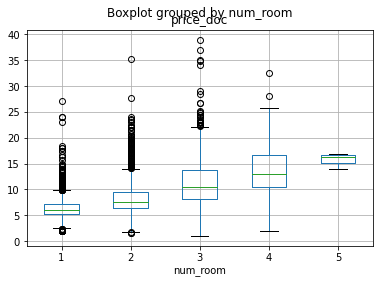

In [257]:
df.boxplot(column=['price_doc'], by='num_room')
df.groupby('num_room')['price_doc'].agg(['min','max','mean','std'])

<a id='4'></a> 
### Модель байесовской линейной регрессии

<a href='#0'> *Вернуться к плану проекта*

In [300]:
df.head(10)

,price_doc,full_sq,life_sq,num_room,kitch_sq,price_log
0,2.7500,11,11,1,12,1.011601
1,7.1000,45,27,2,6,1.960095
2,11.7000,77,50,3,8,2.459589
3,10.4000,56,29,2,10,2.341806
4,6.2000,31,21,1,5,1.824549
5,5.9500,43,27,2,5,1.783391
6,5.9000,46,29,2,5,1.774952
7,2.0000,45,29,2,6,0.693147
8,4.5000,38,24,2,5,1.504077
9,4.5696,54,32,2,9,1.519426


In [314]:
# Takes in a dataframe, finds the most correlated variables with the
# grade and returns training and testing datasets
def format_data(df):
    # Targets are final grade of student
    labels = df['price_log']
    
    # One-Hot Encoding of Categorical Variables
    #df = pd.get_dummies(df)
    
    # Find correlations with the Grade
    most_correlated = df.corr().abs()['price_log'].sort_values(ascending=False)
    
    # Maintain the top 6 most correlation features with Grade
    most_correlated = most_correlated[:5]
    
    df = df.loc[:, most_correlated.index]
    
    # Split into training/testing sets with 25% split
    X_train, X_test, y_train, y_test = train_test_split(df, labels, 
                                                        test_size = 0.25,
                                                        random_state=42)
    
    return X_train, X_test, y_train, y_test

Создадим простую байесовскую линейную модель: 
price ~ full_sq + life_sq + kitch_sq + num_room

In [315]:
data = df[['full_sq', 'life_sq', 'kitch_sq', 'num_room', 'price_log']]
#y = df['price_log']

In [316]:
X_train, X_test, y_train, y_test = format_data(data)
X_train.head()

,price_log,full_sq,life_sq,num_room,kitch_sq
3222,1.704748,32,17,1,6
504,1.740466,35,19,1,10
5568,2.701361,65,42,3,7
4018,2.028148,59,43,3,5
5698,2.224624,52,30,2,8


In [319]:
print(X_train.shape)
print(X_test.shape)

(4094, 5)
(1365, 5)


Посмотрим на корреляцию между признаками и целевой функцией:

C:\Users\Nata\Anaconda3\envs\pymc_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Nata\Anaconda3\envs\pymc_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Nata\Anaconda3\envs\pymc_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar 

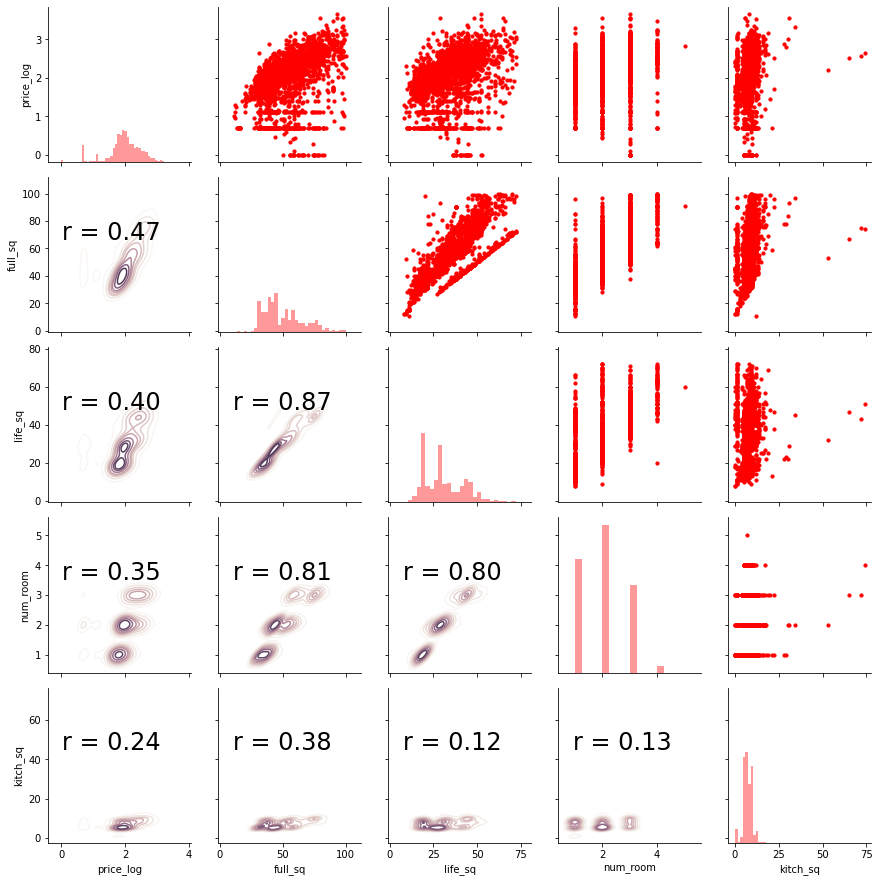

In [322]:
# Calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(X_train)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
C:\Users\Nata\Anaconda3\envs\pymc_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, num_room, kitch_sq, life_sq, full_sq, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 89 seconds.
The acceptance probability does not match the target. It is 0.8856520837347335, but should be close to 0.8. Try to increase the number of tuning steps.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Nata\Anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


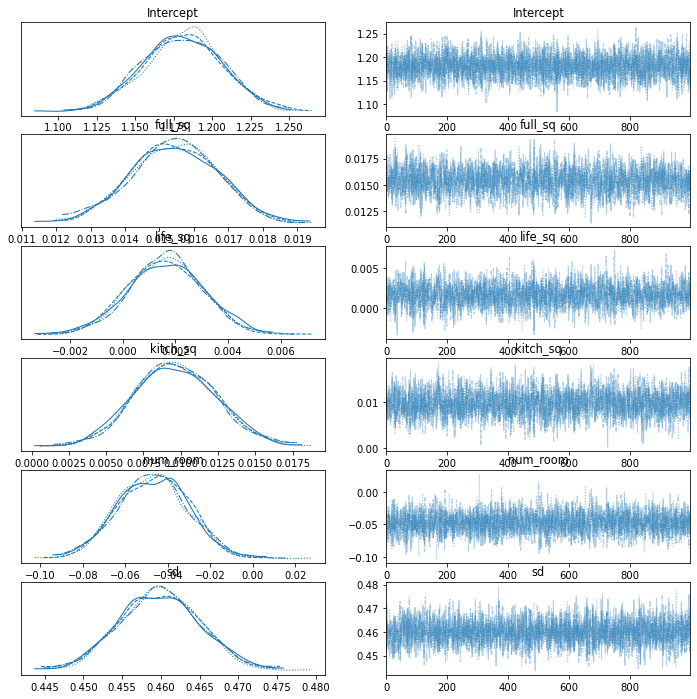

In [334]:
with pm.Model() as lm_model:
    pm.glm.GLM.from_formula('price_log ~ full_sq+life_sq+kitch_sq+num_room', X_train, family = pm.glm.families.Normal())
    trace = pm.sample(1000)
    
az.plot_trace(trace);

In [346]:
#pm.traceplot(trace);
#pm.forestplot(trace);

Другим встроенным методом построения графиков в PyMC3 является апостериорное распределение всех параметров модели. Эти гистограммы позволяют нам увидеть, как результат модели представляет собой распределение параметров, а не одно значение.

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Nata\Anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


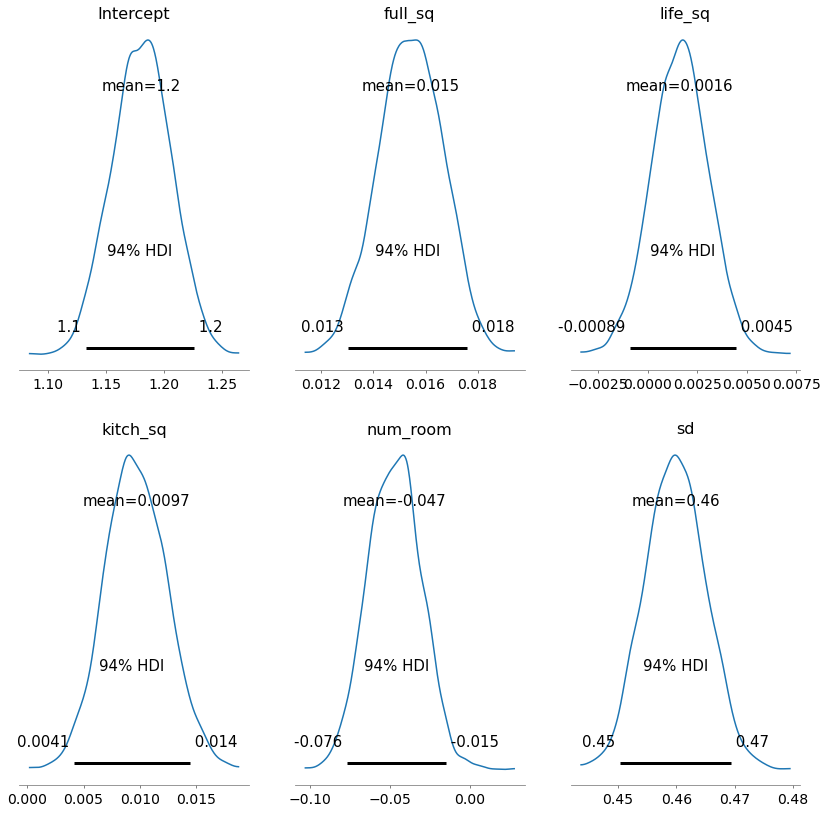

In [345]:
pm.plot_posterior(trace, figsize = (14, 14));

In [347]:
# Print out the mean variable weight from the trace
for variable in trace.varnames:
    print('Variable: {:15} Mean weight in model: {:.4f}'.format(variable, 
                                                                np.mean(trace[variable])))

Variable: Intercept       Mean weight in model: 1.1810
Variable: full_sq         Mean weight in model: 0.0154
Variable: life_sq         Mean weight in model: 0.0016
Variable: kitch_sq        Mean weight in model: 0.0097
Variable: num_room        Mean weight in model: -0.0470
Variable: sd_log__        Mean weight in model: -0.7769
Variable: sd              Mean weight in model: 0.4599


**Построим формулу линейной зависимости цены от признаков модели**

In [353]:
model_formula = 'Price = EXP('
for variable in trace.varnames:
    model_formula += '%0.4f * %s +' % (np.mean(trace[variable]), variable)

' '.join(model_formula.split(' ')[:-1])+')'

'Price = EXP(1.1810 * Intercept +0.0154 * full_sq +0.0016 * life_sq +0.0097 * kitch_sq +-0.0470 * num_room +-0.7769 * sd_log__ +0.4599 * sd)'

In [374]:
# Make a new prediction from the test set and compare to actual value
def test_model(trace, test_observation):
    
    # Print out the test observation data
    print('Test Observation:')
    print(test_observation)
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]

    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Standard deviation of the likelihood
    sd_value = var_weights['sd'].mean()

    # Actual Value
    actual = test_observation['price_log']
    
    # Add in intercept term
    test_observation['Intercept'] = 1
    test_observation = test_observation.drop('price_log')
    
    # Align weights and test observation
    var_weights = var_weights[test_observation.index]

    # Means for all the weights
    var_means = var_weights.mean(axis=0)

    # Location of mean for observation
    mean_loc = np.dot(var_means, test_observation)
    
    # Estimates of grade
    estimates = np.random.normal(loc = mean_loc, scale = sd_value,
                                 size = 1000)

    # Plot all the estimates
    plt.figure()
    sns.distplot(estimates, hist = True, kde = True, bins = 19,
                 hist_kws = {'edgecolor': 'k', 'color': 'darkblue'},
                kde_kws = {'linewidth' : 4},
                label = 'Estimated Dist.')
    # Plot the actual grade
    plt.vlines(x = actual, ymin = 0, ymax = 1, 
               linestyles = '--', colors = 'red',
               label = 'True price',
              linewidth = 2.5)
    
    # Plot the mean estimate
    plt.vlines(x = mean_loc, ymin = 0, ymax = 1, 
               linestyles = '-', colors = 'orange',
               label = 'Mean Estimate',
              linewidth = 2.5)
    
    plt.legend(loc = 1)
    plt.title('Density Plot for Test Observation');
    plt.xlabel('price_log'); plt.ylabel('Density');
    
    # Prediction information
    print('True price = %d' % actual)
    print('Average Estimate = %0.4f' % mean_loc)
    print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
                                       np.percentile(estimates, 95)))

**Тестовые предсказания**

Test Observation:
price_log     2.681022
full_sq      78.000000
life_sq      41.000000
num_room      2.000000
kitch_sq      9.000000
Name: 649, dtype: float64
True price = 2
Average Estimate = 2.4441
5% Estimate = 1.6650    95% Estimate = 3.1811


C:\Users\Nata\AppData\Local\Temp\ipykernel_13324\3303644878.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_observation['Intercept'] = 1
C:\Users\Nata\AppData\Local\Temp\ipykernel_13324\3303644878.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_observation['Intercept'] = 1
C:\Users\Nata\Anaconda3\envs\pymc_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


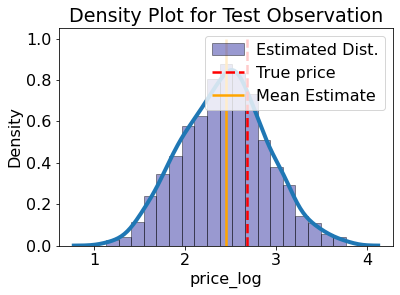

In [375]:
test_model(trace, X_test.iloc[41])

Test Observation:
price_log     1.916923
full_sq      39.000000
life_sq      19.000000
num_room      1.000000
kitch_sq      8.000000
Name: 2772, dtype: float64
True price = 1
Average Estimate = 1.8439
5% Estimate = 1.0315    95% Estimate = 2.6419


C:\Users\Nata\AppData\Local\Temp\ipykernel_13324\3303644878.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_observation['Intercept'] = 1
C:\Users\Nata\AppData\Local\Temp\ipykernel_13324\3303644878.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_observation['Intercept'] = 1
C:\Users\Nata\Anaconda3\envs\pymc_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


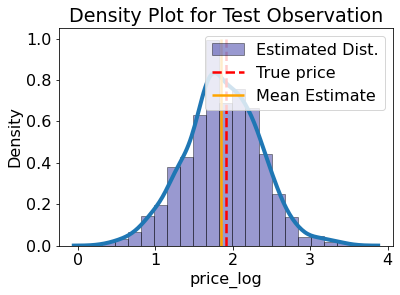

In [379]:
test_model(trace, X_test.iloc[12])

In [407]:
pm.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Nata\Anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.181,0.025,1.133,1.226,0.0,0.0,3436.0,2879.0,1.0
full_sq,0.015,0.001,0.013,0.018,0.0,0.0,2071.0,2216.0,1.0
life_sq,0.002,0.001,-0.001,0.004,0.0,0.0,2431.0,2450.0,1.0
kitch_sq,0.010,0.003,0.004,0.014,0.0,0.0,2412.0,2565.0,1.0
num_room,-0.047,0.017,-0.076,-0.015,0.0,0.0,3021.0,2480.0,1.0
sd,0.460,0.005,0.450,0.469,0.0,0.0,3561.0,2297.0,1.0


In [408]:
lm_model

<a id='5'></a> 
### Модель линейной регрессии sklearn

<a href='#0'> *Вернуться к плану проекта*

In [409]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(data[['full_sq', 'life_sq', 'kitch_sq', 'num_room']], data['price_log'])

LinearRegression()

In [410]:
lr.intercept_

1.1671243935565148

In [411]:
pd.DataFrame(lr.coef_, index=['full_sq', 'life_sq', 'kitch_sq', 'num_room'])

,0
full_sq,0.016203
life_sq,0.000653
kitch_sq,0.010515
num_room,-0.045694


In [293]:
lr.feature_names_in_

array(['full_sq', 'life_sq', 'kitch_sq', 'num_room'], dtype=object)

In [294]:
lr.coef_

array([ 0.01620264,  0.0006533 ,  0.01051503, -0.04569373])

Попрбуем предсказать стоимость 3- комнатной квартиры:

In [296]:
np.exp(lr.predict(np.array([[81,72,14,3]])))

C:\Users\Nata\Anaconda3\envs\pymc_env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([12.63795774])

12.638 млн

<a id='6'></a> 
### Выводы

<a href='#0'> *Вернуться к плану проекта*

Сравнение получившиеся коэффициенты классической линейной регрессии с коэффициентами при признаках в байесовской линейной регрессии показывет, что они практически совпадают.